# Recurrent Neural Networks Demo
This is a truncated and slightly modified version of an RNN demo by 95-865 Fall 2017 TA Runshan Fu

### Sentiment Analysis with the IMDb Dataset
In this demo, we will implement RNN models for sentiment analysis on IMDB reviews. We will start from the original review texts and predict sentiments (positive or negative) for each review. The example is borrowed from the book *Deep Learning with Python* by Francois Chollet.

#### Load the dataset
We directly load the data as lists of intergers from keras. We restrict the movie reviews to the top 10,000 most common words, and cut the reviews after 100 words.

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# load the dataset and only keep the top words (most frequently occurring)
max_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

# turn the lists of integers into a 2D integer tensor of shape `(samples, maxlen)`
x_train = sequence.pad_sequences(x_train, maxlen=100)
x_test = sequence.pad_sequences(x_test, maxlen=100)

Using TensorFlow backend.


In [3]:
x_train.shape

(25000, 100)

#### Use pre-trained word embeddings
We use GloVe embeddings instead of learning our own task-specific word embedding. First download the pre-computed embeddings from 2014 English Wikipedia on https://nlp.stanford.edu/projects/glove/ (specifically the one with 6 billion tokens, `globe.6B.zip`). Unzip it (so that `glove.6B.100d.txt` is located in the directory `./glove/`).

In [4]:
import numpy as np
# pre-process the embeddings
embeddings_index = {}

# we will use the 100-dimensional embedding vectors
with open("./glove/glove.6B.100d.txt") as f:
    # each row represents a word vector
    for line in f:
        values = line.split()
        # the first part is word
        word = values[0]
        # the rest of the values form the embedding vector
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [6]:
# prepare the GloVe word embeddings matrix
embedding_dim = 100

# word index is a dictinary that maps each word to its index
word_index = imdb.get_word_index()
# we first initialize the embedding matrix with zeros
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    # we get the word embeddings for each word from GloVe
    embedding_vector = embeddings_index.get(word)
    # we only look at top 10000 words
    if i < max_words:
        # if the embedding vector for the word exists in GloVe, we use it as the corresponding row in the 
        # embedding matrix; otherwise we leave the row as all zeros
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### Forward Network with Embeddings

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
# initialize the model
model = Sequential()
# add the embedding layer; it takes 3 arguments: the total number of words (10000), 
# embedding dimension(100), and the input length (100)--the last argument is required 
# as we are going to connect Flatten then Dense layers (without it, the shape of
# the dense outputs cannot be computed).
model.add(Embedding(max_words, embedding_dim, input_length=100))
# then flatten the 3D tensor into a 2D matrix as the input for the subsequent layer
model.add(Flatten())
# add a dense layer with 32 nodes
model.add(Dense(32, activation='relu'))
# add a logistic regression binary classifier
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [8]:
# load the GloVe embeddings in the model
model.layers[0].set_weights([embedding_matrix]) #force the weights to come from the embedding layer from Glove
# set the embedding layer to be not trainable, so the weights do not change during the training
model.layers[0].trainable = False

In [9]:
# compile and train the model
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', # suitable for just 1 neuron as output
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s 280us/step - loss: 0.7056 - acc: 0.4946 - val_loss: 0.6932 - val_acc: 0.4938
Epoch 2/10
20000/20000 [==============================] - 5s 234us/step - loss: 0.6937 - acc: 0.5069 - val_loss: 0.6898 - val_acc: 0.5378
Epoch 3/10
20000/20000 [==============================] - 5s 235us/step - loss: 0.6768 - acc: 0.5718 - val_loss: 0.6792 - val_acc: 0.5612
Epoch 4/10
20000/20000 [==============================] - 5s 233us/step - loss: 0.6286 - acc: 0.6475 - val_loss: 0.6926 - val_acc: 0.5744
Epoch 5/10
20000/20000 [==============================] - 5s 233us/step - loss: 0.5848 - acc: 0.6925 - val_loss: 0.7080 - val_acc: 0.5820
Epoch 6/10
20000/20000 [==============================] - 5s 233us/step - loss: 0.5413 - acc: 0.7231 - val_loss: 0.7859 - val_acc: 0.5706
Epoch 7/10
20000/20000 [==============================] - 5s 235us/step - loss: 0.4992 - acc: 0.7516 - val_loss: 0.9772 - v

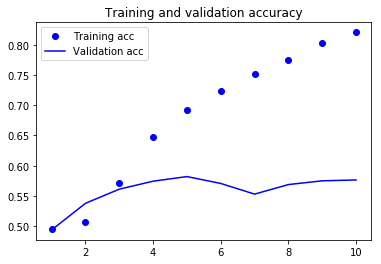

In [10]:
# plot the accuracy rates for each epoch on training and validation data
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

25000/25000 [==============================] - 2s 93us/step
Test accuracy: 0.56804


#### LSTM

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim))
model.add(LSTM(embedding_dim))
model.add(Dense(1, activation='sigmoid'))
# load the GloVe embeddings in the model
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 1,080,501
Trainable params: 80,501
Non-trainable params: 1,000,000
_________________________________________________________________


In [13]:
# compile and train the model
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.6775 - acc: 0.5672 - val_loss: 0.6513 - val_acc: 0.6068
Epoch 2/10
20000/20000 [==============================] - 67s 3ms/step - loss: 0.6268 - acc: 0.6399 - val_loss: 0.5972 - val_acc: 0.6636
Epoch 3/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.5783 - acc: 0.6900 - val_loss: 0.6020 - val_acc: 0.6662
Epoch 4/10
20000/20000 [==============================] - 62s 3ms/step - loss: 0.5269 - acc: 0.7319 - val_loss: 0.5355 - val_acc: 0.7172
Epoch 5/10
20000/20000 [==============================] - 62s 3ms/step - loss: 0.4779 - acc: 0.7661 - val_loss: 0.5224 - val_acc: 0.7278
Epoch 6/10
20000/20000 [==============================] - 67s 3ms/step - loss: 0.4326 - acc: 0.7945 - val_loss: 0.5094 - val_acc: 0.7386
Epoch 7/10
20000/20000 [==============================] - 65s 3ms/step - loss: 0.3899 - acc: 0.8226 - val_loss: 0.4958 - val_acc:

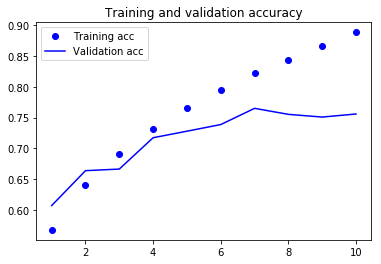

In [14]:
# plot the accuracy rates for each epoch on training and validation data
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

25000/25000 [==============================] - 24s 961us/step
Test accuracy: 0.75644
